In [145]:
import os
from typing import Optional, Tuple, List, Union, Callable

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm import trange

In [146]:
if not os.path.exists('tiny_nerf_data.npz'):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Images shape: (106, 100, 100, 3)
Poses shape: (106, 4, 4)
Focal length: 138.88887889922103
Pose
[[ 6.8935126e-01  5.3373039e-01 -4.8982298e-01 -1.9745398e+00]
 [-7.2442728e-01  5.0788772e-01 -4.6610624e-01 -1.8789345e+00]
 [ 1.4901163e-08  6.7615211e-01  7.3676193e-01  2.9699826e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


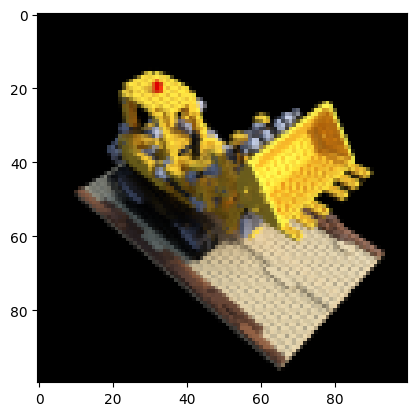

In [147]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

print(f'Images shape: {images.shape}')
print(f'Poses shape: {poses.shape}')
print(f'Focal length: {focal}')

height, width = images.shape[1:3]
near, far = 2., 6.

n_training = 100
testimg_idx = 101
testimg, testpose = images[testimg_idx], poses[testimg_idx]

plt.imshow(testimg)
print('Pose')
print(testpose)

In [148]:
images = torch.from_numpy(data['images'][:n_training]).to(device)
poses = torch.from_numpy(data['poses']).to(device)
focal = torch.from_numpy(data['focal']).to(device)
testimg = torch.from_numpy(data['images'][testimg_idx]).to(device)
testpose = torch.from_numpy(data['poses'][testimg_idx]).to(device)

In [149]:
def get_rays(
  h: int,
  w: int,
  f: float,
  c: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
  """
  Determine ray origin and direction for each pixel.
  """

  # Apply pinhole camera model to find directions at each pixel
  i, j = torch.meshgrid(
      torch.arange(w, dtype=torch.float32).to(c),
      torch.arange(h, dtype=torch.float32).to(c),
      indexing='ij')
  i, j = i.transpose(-1, -2), j.transpose(-1, -2)
  dirs = torch.stack([(i - w * .5) / f,
                            -(j - h * .5) / f,
                            -torch.ones_like(i)
                           ], dim=-1)

  # Apply camera pose to directions
  rd = torch.sum(dirs[..., None, :] * c[:3, :3], dim=-1)

  # Origin is the same for all directions (the optical center)
  ro = c[:3, -1].expand(rd.shape)
  return ro, rd

In [150]:
def sample_stratified(
  ro: torch.Tensor,
  rd: torch.Tensor,
  n: float,
  f: float,
  n_samples: int,
  perturb: Optional[bool] = True,
  inverse_depth: bool = False
) -> Tuple[torch.Tensor, torch.Tensor]:
  """
  Sample along ray from regularly-spaced bins.
  """

  # Obtain samples for space integration along ray
  ts = torch.linspace(0., 1., n_samples, device=ro.device)
  if not inverse_depth:
    # Sample linearly between `near` and `far`
    zs = n * (1. - ts) + f * ts
  else:
    # Sample linearly in inverse depth (disparity)
    zs = 1. / (1. / n * (1. - ts) + 1. / f * ts)

  # Draw uniform samples from bins along ray
  if perturb:
    m = .5 * (zs[1:] + zs[:-1])
    u = torch.cat([m, zs[-1:]], dim=-1)
    l = torch.cat([zs[:1], m], dim=-1)
    t_r = torch.rand([n_samples], device=zs.device)
    zs = l + (u - l) * t_r
  zs = zs.expand(list(ro.shape[:-1]) + [n_samples])

  # Apply scale from `rays_d` and offset from `rays_o` to samples
  # pts: (width, height, n_samples, 3)
  pts = ro[..., None, :] + rd[..., None, :] * zs[..., :, None]
  return pts, zs

In [151]:
class PE(nn.Module):
  r"""
  Sine-cosine positional encoder for input points.
  """
  def __init__(
    self,
    d_input: int,
    n_freqs: int,
    log_space: bool = False
  ):
    super().__init__()
    self.d_input = d_input
    self.n_freqs = n_freqs
    self.log_space = log_space
    self.d_output = d_input * (1 + 2 * self.n_freqs)
    self.embed_fns = [lambda x: x]

    # Define frequencies in either linear or log scale
    if self.log_space:
      freq_bands = 2.**torch.linspace(0., self.n_freqs - 1, self.n_freqs)
    else:
      freq_bands = torch.linspace(2.**0., 2.**(self.n_freqs - 1), self.n_freqs)

    # Alternate sin and cos
    for freq in freq_bands:
      self.embed_fns.append(lambda x, freq=freq: torch.sin(x * freq))
      self.embed_fns.append(lambda x, freq=freq: torch.cos(x * freq))

  def forward(
    self,
    x
  ) -> torch.Tensor:
    r"""
    Apply positional encoding to input.
    """
    return torch.concat([fn(x) for fn in self.embed_fns], dim=-1)

In [152]:
class NeRF(nn.Module):
  r"""
  Neural radiance fields module.
  """
  def __init__(
    self,
    d_input: int = 3,
    n_layers: int = 8,
    d_filter: int = 256,
    skip: Tuple[int] = (4,),
    d_viewdirs: Optional[int] = None
  ):
    super().__init__()
    self.d_input = d_input
    self.skip = skip
    self.act = nn.functional.relu
    self.d_viewdirs = d_viewdirs

    # Create model layers
    self.layers = nn.ModuleList(
      [nn.Linear(self.d_input, d_filter)] +
      [nn.Linear(d_filter + self.d_input, d_filter) if i in skip \
       else nn.Linear(d_filter, d_filter) for i in range(n_layers - 1)]
    )

    # Bottleneck layers
    if self.d_viewdirs is not None:
      # If using viewdirs, split alpha and RGB
      self.alpha_out = nn.Linear(d_filter, 1)
      self.rgb_filters = nn.Linear(d_filter, d_filter)
      self.branch = nn.Linear(d_filter + self.d_viewdirs, d_filter // 2)
      self.output = nn.Linear(d_filter // 2, 3)
    else:
      # If no viewdirs, use simpler output
      self.output = nn.Linear(d_filter, 4)

  def forward(
    self,
    x: torch.Tensor,
    viewdirs: Optional[torch.Tensor] = None
  ) -> torch.Tensor:
    r"""
    Forward pass with optional view direction.
    """

    # Cannot use viewdirs if instantiated with d_viewdirs = None
    if self.d_viewdirs is None and viewdirs is not None:
      raise ValueError('Cannot input x_direction if d_viewdirs was not given.')

    # Apply forward pass up to bottleneck
    x_input = x
    for i, layer in enumerate(self.layers):
      x = self.act(layer(x))
      if i in self.skip:
        x = torch.cat([x, x_input], dim=-1)

    # Apply bottleneck
    if self.d_viewdirs is not None:
      # Split alpha from network output
      alpha = self.alpha_out(x)

      # Pass through bottleneck to get RGB
      x = self.rgb_filters(x)
      x = torch.concat([x, viewdirs], dim=-1)
      x = self.act(self.branch(x))
      x = self.output(x)

      # Concatenate alphas to output
      x = torch.concat([x, alpha], dim=-1)
    else:
      # Simple output
      x = self.output(x)
    return x

In [153]:
def cpex(t: torch.Tensor) -> torch.Tensor:
  cp = torch.cumprod(t, -1)
  cp = torch.roll(cp, 1, -1)
  cp[..., 0] = 1.
  return cp

def r2o(r: torch.Tensor, z: torch.Tensor, d: torch.Tensor, ns: float = 0.0, wb: bool = False) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
  d = z[..., 1:] - z[..., :-1]
  d = torch.cat([d, 1e10 * torch.ones_like(d[..., :1])], dim=-1)
  d = d * torch.norm(d[..., None, :], dim=-1)
  n = 0.
  if ns > 0.:
    n = torch.randn(r[..., 3].shape) * ns
  a = 1.0 - torch.exp(-nn.functional.relu(r[..., 3] + n) * d)
  w = a * cpex(1. - a + 1e-10)
  rgb = torch.sigmoid(r[..., :3])
  rgb_map = torch.sum(w[..., None] * rgb, dim=-2)
  dm = torch.sum(w * z, dim=-1)
  disp_map = 1. / torch.max(1e-10 * torch.ones_like(dm), dm / torch.sum(w, -1))
  am = torch.sum(w, dim=-1)
  if wb:
    rgb_map = rgb_map + (1. - am[..., None])
  return rgb_map, dm, am, w

In [154]:
def sample_pdf(b: torch.Tensor, w: torch.Tensor, ns: int, p: bool = False) -> torch.Tensor:
  """
  Apply inverse transform sampling to a weighted set of points.
  """

  # Normalize weights to get PDF.
  pdf = (w + 1e-5) / torch.sum(w + 1e-5, -1, keepdims=True)

  # Convert PDF to CDF.
  cdf = torch.cumsum(pdf, dim=-1)
  cdf = torch.cat([torch.zeros_like(cdf[..., :1]), cdf], dim=-1)

  # Take sample positions to grab from CDF. Linear when perturb == 0.
  if not p:
    u = torch.linspace(0., 1., ns, device=cdf.device)
    u = u.expand(list(cdf.shape[:-1]) + [ns])
  else:
    u = torch.rand(list(cdf.shape[:-1]) + [ns], device=cdf.device)

  # Find indices along CDF where values in u would be placed.
  u = u.contiguous()
  i = torch.searchsorted(cdf, u, right=True)

  # Clamp indices that are out of bounds.
  b_i = torch.clamp(i - 1, min=0)
  a_i = torch.clamp(i, max=cdf.shape[-1] - 1)
  inds_g = torch.stack([b_i, a_i], dim=-1)

  # Sample from cdf and the corresponding bin centers.
  ms = list(inds_g.shape[:-1]) + [cdf.shape[-1]]
  cdf_g = torch.gather(cdf.unsqueeze(-2).expand(ms), dim=-1, index=inds_g)
  bins_g = torch.gather(b.unsqueeze(-2).expand(ms), dim=-1, index=inds_g)

  # Convert samples to ray length.
  denom = (cdf_g[..., 1] - cdf_g[..., 0])
  denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
  t = (u - cdf_g[..., 0]) / denom
  s = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

  return s


In [155]:
def sample_hierarchical(ro: torch.Tensor, rd: torch.Tensor, z: torch.Tensor, w: torch.Tensor, ns: int, perturb: bool = False) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
  """
  Apply hierarchical sampling to the rays.
  """

  # Draw samples from PDF using z_vals as bins and weights as probabilities.
  zm = .5 * (z[..., 1:] + z[..., :-1])
  nz = sample_pdf(zm, w[..., 1:-1], ns, perturb)
  nz = nz.detach()

  # Resample points from ray based on PDF.
  zc, _ = torch.sort(torch.cat([z, nz], dim=-1), dim=-1)
  p = ro[..., None, :] + rd[..., None, :] * zc[..., :, None]
  return p, zc, nz


In [156]:
def get_chunks(inputs: torch.Tensor, chunksize: int = 2**15) -> List[torch.Tensor]:
    """
    Divide a tensor into smaller chunks for processing.
    """
    return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]


def prepare_chunks(points: torch.Tensor, encoding_fn: Callable[[torch.Tensor], torch.Tensor], chunksize: int = 2**15) -> List[torch.Tensor]:
    """
    Encode 3D points and divide them into manageable chunks.
    """
    points = points.reshape((-1, 3))
    points = encoding_fn(points)
    points = get_chunks(points, chunksize=chunksize)
    return points


def prepare_viewdirs_chunks(points: torch.Tensor, rays_d: torch.Tensor, encoding_fn: Callable[[torch.Tensor], torch.Tensor], chunksize: int = 2**15) -> List[torch.Tensor]:
    """
    Encode view directions and partition them into chunks for efficient processing.
    """
    viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
    viewdirs = viewdirs[:, None, ...].expand(points.shape).reshape((-1, 3))
    viewdirs = encoding_fn(viewdirs)
    viewdirs = get_chunks(viewdirs, chunksize=chunksize)
    return viewdirs

In [157]:
def nerf_forward(rays_o: torch.Tensor, rays_d: torch.Tensor, near: float, far: float, encoding_fn: Callable[[torch.Tensor], torch.Tensor], coarse_model: nn.Module, kwargs_sample_stratified: dict = None, n_samples_hierarchical: int = 0, kwargs_sample_hierarchical: dict = None, fine_model = None, viewdirs_encoding_fn: Optional[Callable[[torch.Tensor], torch.Tensor]] = None, chunksize: int = 2**15) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, dict]:
    """
    Perform a forward pass through a NeRF (Neural Radiance Fields) model.

    Args:
        rays_o: Origin of the rays.
        rays_d: Direction of the rays.
        near: Near plane distance.
        far: Far plane distance.
        encoding_fn: Function for encoding input points.
        coarse_model: Coarse model for predicting radiance.
        kwargs_sample_stratified: Additional arguments for stratified sampling.
        n_samples_hierarchical: Number of samples for hierarchical sampling.
        kwargs_sample_hierarchical: Additional arguments for hierarchical sampling.
        fine_model: Fine model for refining radiance predictions.
        viewdirs_encoding_fn: Function for encoding view directions.
        chunksize: Size of chunks for processing.

    Returns:
        Tuple containing RGB map, depth map, accumulation map, and additional outputs.
    """

    if kwargs_sample_stratified is None:
        kwargs_sample_stratified = {}
    if kwargs_sample_hierarchical is None:
        kwargs_sample_hierarchical = {}

    query_points, z_vals = sample_stratified(rays_o, rays_d, near, far, **kwargs_sample_stratified)
    batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
    batches_viewdirs = prepare_viewdirs_chunks(query_points, rays_d, viewdirs_encoding_fn, chunksize=chunksize) if viewdirs_encoding_fn is not None else [None] * len(batches)

    predictions = [coarse_model(batch, viewdirs=batch_viewdirs) for batch, batch_viewdirs in zip(batches, batches_viewdirs)]
    raw = torch.cat(predictions, dim=0).reshape(list(query_points.shape[:2]) + [predictions[0].shape[-1]])
    rgb_map, depth_map, acc_map, weights = r2o(raw, z_vals, rays_d)

    outputs = {'z_vals_stratified': z_vals}

    if n_samples_hierarchical > 0:
        rgb_map_0, depth_map_0, acc_map_0 = rgb_map, depth_map, acc_map
        query_points, z_vals_combined, z_hierarch = sample_hierarchical(rays_o, rays_d, z_vals, weights, n_samples_hierarchical, **kwargs_sample_hierarchical)
        batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
        batches_viewdirs = prepare_viewdirs_chunks(query_points, rays_d, viewdirs_encoding_fn, chunksize=chunksize) if viewdirs_encoding_fn is not None else [None] * len(batches)
        fine_model = fine_model if fine_model is not None else coarse_model
        predictions = [fine_model(batch, viewdirs=batch_viewdirs) for batch, batch_viewdirs in zip(batches, batches_viewdirs)]
        raw = torch.cat(predictions, dim=0).reshape(list(query_points.shape[:2]) + [predictions[0].shape[-1]])
        rgb_map, depth_map, acc_map, weights = r2o(raw, z_vals_combined, rays_d)
        outputs.update({'z_vals_hierarchical': z_hierarch, 'rgb_map_0': rgb_map_0, 'depth_map_0': depth_map_0, 'acc_map_0': acc_map_0})

    outputs.update({'rgb_map': rgb_map, 'depth_map': depth_map, 'acc_map': acc_map, 'weights': weights})
    return outputs

In [158]:
d_input = 3
n_freqs = 10
log_space = True
use_viewdirs = True
n_freqs_views = 4

n_samples = 64
perturb = True
inverse_depth = False

d_filter = 128
n_layers = 2
skip = []
use_fine_model = True
d_filter_fine = 128
n_layers_fine = 6

n_samples_hierarchical = 64
perturb_hierarchical = False

lr = 5e-4

n_iters = 10000
batch_size = 2**14
one_image_per_step = True
chunksize = 2**14
center_crop = True
center_crop_iters = 50
display_rate = 25

warmup_iters = 100
warmup_min_fitness = 10.0
n_restarts = 10

kwargs_sample_stratified = {
    'n_samples': n_samples,
    'perturb': perturb,
    'inverse_depth': inverse_depth
}
kwargs_sample_hierarchical = {
    'perturb': perturb
}

In [159]:
def plot_samples(z_vals: torch.Tensor, z_hierarch: Optional[torch.Tensor] = None, ax: Optional[np.ndarray] = None):
    """
    Plot stratified and hierarchical samples.
    """
    y_vals = 1 + np.zeros_like(z_vals)

    if ax is None:
        ax = plt.subplot()
    ax.plot(z_vals, y_vals, 'b-o')
    if z_hierarch is not None:
        y_hierarch = np.zeros_like(z_hierarch)
        ax.plot(z_hierarch, y_hierarch, 'r-o')
    ax.set_ylim([-1, 2])
    ax.set_title('Stratified Samples (blue) and Hierarchical Samples (red)')
    ax.axes.yaxis.set_visible(False)
    ax.grid(True)
    return ax


def crop_center(img: torch.Tensor, frac: float = 0.5) -> torch.Tensor:
    """
    Crop the center square from an image.
    """
    h_offset = round(img.shape[0] * (frac / 2))
    w_offset = round(img.shape[1] * (frac / 2))
    return img[h_offset:-h_offset, w_offset:-w_offset]


class EarlyStopping:
    """
    Helper class for early stopping based on a fitness criterion.
    """
    def __init__(self, patience: int = 30, margin: float = 1e-4):
        self.best_fitness = 0.0  # In our case PSNR
        self.best_iter = 0
        self.margin = margin
        self.patience = patience or float('inf')  # epochs to wait after fitness stops improving to stop

    def __call__(self, iter: int, fitness: float):
        """
        Check if the criterion for stopping is met.
        """
        if (fitness - self.best_fitness) > self.margin:
            self.best_iter = iter
            self.best_fitness = fitness
        delta = iter - self.best_iter
        stop = delta >= self.patience  # stop training if patience exceeded
        return stop

In [160]:
def init_models():
    """
    Initialize models, encoders, and optimizer for NeRF training.
    """
    # Encoders
    encoder = PE(d_input, n_freqs, log_space=log_space)
    encode = lambda x: encoder(x)

    # View direction encoders
    if use_viewdirs:
        encoder_viewdirs = PE(d_input, n_freqs_views, log_space=log_space)
        encode_viewdirs = lambda x: encoder_viewdirs(x)
        d_viewdirs = encoder_viewdirs.d_output
    else:
        encode_viewdirs = None
        d_viewdirs = None

    # Models
    model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip, d_viewdirs=d_viewdirs)
    model.to(device)
    model_params = list(model.parameters())
    if use_fine_model:
        fine_model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip, d_viewdirs=d_viewdirs)
        fine_model.to(device)
        model_params += list(fine_model.parameters())
    else:
        fine_model = None

    # Optimizer
    optimizer = torch.optim.Adam(model_params, lr=lr)

    # Early Stopping
    warmup_stopper = EarlyStopping(patience=50)

    return model, fine_model, encode, encode_viewdirs, optimizer, warmup_stopper

In [161]:
def train():
  r"""
  Launch training session for NeRF.
  """
  # Shuffle rays across all images.
  if not one_image_per_step:
    height, width = images.shape[1:3]
    all_rays = torch.stack([torch.stack(get_rays(height, width, focal, p), 0)
                        for p in poses[:n_training]], 0)
    rays_rgb = torch.cat([all_rays, images[:, None]], 1)
    rays_rgb = torch.permute(rays_rgb, [0, 2, 3, 1, 4])
    rays_rgb = rays_rgb.reshape([-1, 3, 3])
    rays_rgb = rays_rgb.type(torch.float32)
    rays_rgb = rays_rgb[torch.randperm(rays_rgb.shape[0])]
    i_batch = 0

  train_psnrs = []
  val_psnrs = []
  iternums = []
  for i in trange(n_iters):
    model.train()

    if one_image_per_step:
      # Randomly pick an image as the target.
      target_img_idx = np.random.randint(images.shape[0])
      target_img = images[target_img_idx].to(device)
      if center_crop and i < center_crop_iters:
        target_img = crop_center(target_img)
      height, width = target_img.shape[:2]
      target_pose = poses[target_img_idx].to(device)
      rays_o, rays_d = get_rays(height, width, focal, target_pose)
      rays_o = rays_o.reshape([-1, 3])
      rays_d = rays_d.reshape([-1, 3])
    else:
      # Random over all images.
      batch = rays_rgb[i_batch:i_batch + batch_size]
      batch = torch.transpose(batch, 0, 1)
      rays_o, rays_d, target_img = batch
      height, width = target_img.shape[:2]
      i_batch += batch_size
      # Shuffle after one epoch
      if i_batch >= rays_rgb.shape[0]:
          rays_rgb = rays_rgb[torch.randperm(rays_rgb.shape[0])]
          i_batch = 0
    target_img = target_img.reshape([-1, 3])

    # Run one iteration of TinyNeRF and get the rendered RGB image.
    outputs = nerf_forward(rays_o, rays_d,
                           near, far, encode, model,
                           kwargs_sample_stratified=kwargs_sample_stratified,
                           n_samples_hierarchical=n_samples_hierarchical,
                           kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                           fine_model=fine_model,
                           viewdirs_encoding_fn=encode_viewdirs,
                           chunksize=chunksize)

    # Check for any numerical issues.
    for k, v in outputs.items():
      if torch.isnan(v).any():
        print(f"! [Numerical Alert] {k} contains NaN.")
      if torch.isinf(v).any():
        print(f"! [Numerical Alert] {k} contains Inf.")

    # Backprop!
    rgb_predicted = outputs['rgb_map']
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    psnr = -10. * torch.log10(loss)
    train_psnrs.append(psnr.item())

    # Evaluate testimg at given display rate.
    if i % display_rate == 0:
      model.eval()
      height, width = testimg.shape[:2]
      rays_o, rays_d = get_rays(height, width, focal, testpose)
      rays_o = rays_o.reshape([-1, 3])
      rays_d = rays_d.reshape([-1, 3])
      outputs = nerf_forward(rays_o, rays_d,
                             near, far, encode, model,
                             kwargs_sample_stratified=kwargs_sample_stratified,
                             n_samples_hierarchical=n_samples_hierarchical,
                             kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                             fine_model=fine_model,
                             viewdirs_encoding_fn=encode_viewdirs,
                             chunksize=chunksize)

      rgb_predicted = outputs['rgb_map']
      loss = torch.nn.functional.mse_loss(rgb_predicted, testimg.reshape(-1, 3))
      print("Loss:", loss.item())
      val_psnr = -10. * torch.log10(loss)
      val_psnrs.append(val_psnr.item())
      iternums.append(i)

      # Plot example outputs
      fig, ax = plt.subplots(1, 4, figsize=(24,4), gridspec_kw={'width_ratios': [1, 1, 1, 3]})
      ax[0].imshow(rgb_predicted.reshape([height, width, 3]).detach().cpu().numpy())
      ax[0].set_title(f'Iteration: {i}')
      ax[1].imshow(testimg.detach().cpu().numpy())
      ax[1].set_title(f'Target')
      ax[2].plot(range(0, i + 1), train_psnrs, 'r')
      ax[2].plot(iternums, val_psnrs, 'b')
      ax[2].set_title('PSNR (train=red, val=blue')
      z_vals_strat = outputs['z_vals_stratified'].view((-1, n_samples))
      z_sample_strat = z_vals_strat[z_vals_strat.shape[0] // 2].detach().cpu().numpy()
      if 'z_vals_hierarchical' in outputs:
        z_vals_hierarch = outputs['z_vals_hierarchical'].view((-1, n_samples_hierarchical))
        z_sample_hierarch = z_vals_hierarch[z_vals_hierarch.shape[0] // 2].detach().cpu().numpy()
      else:
        z_sample_hierarch = None
      _ = plot_samples(z_sample_strat, z_sample_hierarch, ax=ax[3])
      ax[3].margins(0)
      plt.show()

    # Check PSNR for issues and stop if any are found.
    if i == warmup_iters - 1:
      if val_psnr < warmup_min_fitness:
        print(f'Val PSNR {val_psnr} below warmup_min_fitness {warmup_min_fitness}. Stopping...')
        return False, train_psnrs, val_psnrs
    elif i < warmup_iters:
      if warmup_stopper is not None and warmup_stopper(i, psnr):
        print(f'Train PSNR flatlined at {psnr} for {warmup_stopper.patience} iters. Stopping...')
        return False, train_psnrs, val_psnrs

  return True, train_psnrs, val_psnrs

In [1]:
# Run training session(s)
for _ in range(n_restarts):
    model, fine_model, encode, encode_viewdirs, optimizer, warmup_stopper = init_models()
    success, train_psnrs, val_psnrs = train()
    if success and val_psnrs[-1] >= warmup_min_fitness:
        print('Training successful!')
        break

print('')
print(f'Done!')

NameError: name 'n_restarts' is not defined